# ERA5 CCKWs events selection

## Import package

In [18]:
import sys
import numpy as np
import pandas as pd
import netCDF4 as nc

from matplotlib import pyplot as plt

sys.path.append("/home/b11209013/Package")
import Theory as th
import DataProcess as dp

## Functions

### Bandpass filter mask 

In [19]:
def mask(wnm, frm):
    """
    Checks if (wnm, frm) lies in either the positive or negative region.

    Parameters:
        wnm: The wavenumber.
        frm: The frequency.

    Returns:
        A tuple of booleans (is_in_positive_region, is_in_negative_region):
        - is_in_positive_region: True if (wnm, frm) lies in the positive region.
        - is_in_negative_region: True if (wnm, frm) lies in the negative region.
    """
    kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k

    is_in_positive_region = (
        (wnm >= 1) & (wnm <= 14) &
        (frm >= 1 / 20) & (frm <= 1 / 2.5) &
        (frm <= kel_curves(90, wnm)) &
        (frm >= kel_curves(8, wnm))
    )
    
    is_in_negative_region = (
        (wnm <= -1) & (wnm >= -14) &
        (frm <= -1 / 20) & (frm >= -1 / 2.5) &
        (frm >= kel_curves(90, wnm)) &
        (frm <= kel_curves(8, wnm))
    )
    
    return np.where(is_in_positive_region | is_in_negative_region, 1, 0)

## Load data

In [20]:
# setting date range
date = pd.date_range(start='1979-01-01', periods=15706, freq='D')

idx_str: int = np.where(date == '2006-01-01')[0][0]
idx_end: int = np.where(date == '2017-12-31')[0][0]

# load Q1 File
dims: dict[str, np.ndarray] = dict()

with nc.Dataset("/work/b11209013/2024_Research/nstcCCKW/Q1/Q1Flt.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:]
    
    lat_lim: list[int] = np.where((dims['lat'] >= -5) & (dims['lat'] <= 5))[0]
    
    dims["lat"]  = dims["lat"][lat_lim]
    dims["time"] = dims["time"][idx_str:idx_end]
    q1: np.ndarray = f.variables['Q1'][idx_str:idx_end, :, lat_lim, :]
    
ltime, llev, llat, llon = q1.shape
print("Q1 shape:", q1.shape)

Q1 shape: (4382, 38, 20, 576)


## Vertical integral Q1

In [21]:
# Function
def vert_int(
        data: np.ndarray,
        lev : np.ndarray,
) -> np.ndarray:
    
    data_ave : np.ndarray = (data[:, 1:] + data[:, :-1])/2
    data_vint: np.ndarray = -np.sum(data_ave * (dims["lev"][1:] - dims["lev"][:-1])[None, :, None, None], axis=1) * 86400/9.8/2.5e6

    return data_vint

q1_vint: np.ndarray = vert_int(q1, dims['lev'])
print("Vertical integrated Q1 shape:", q1_vint.shape)

Vertical integrated Q1 shape: (4382, 20, 576)


## Process data

### Symmetrizing data

In [22]:
fmt = dp.Format(dims["lat"])

q1_sym: np.ndarray = fmt.sym(q1_vint)

print("symmetrize q1 shape:", q1_sym.shape)

symmetrize q1 shape: (4382, 576)


### FFT

In [32]:
# symmetric data
sym_fft: np.ndarray = np.fft.fft(q1_sym, axis=1)
sym_fft             = np.fft.ifft(sym_fft, axis=0)

# mask
wn: np.ndarray = np.fft.fftfreq(llon, d=1/llon).astype(int)
fr: np.ndarray = np.fft.fftfreq(ltime, d=1)

wnm, frm = np.meshgrid(wn, fr)
mask_arr: np.ndarray = mask(wnm, frm)

q1_mask: np.ndarray = sym_fft * mask_arr


### Reconstruction

In [36]:
kel_recon: np.ndarray = np.fft.ifft(np.fft.fft(q1_mask, axis=0), axis=1).real

## Statistic test

Null Hypothesis: The vertical integrated Q1 is not significantly greater than 0.\
Criteria: 99%, Z-test, single tailed 

### Criteria setting

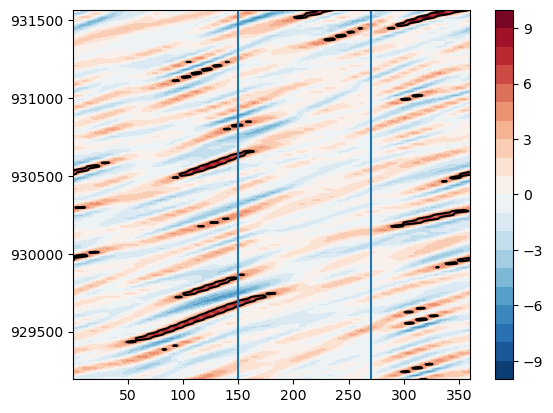

In [41]:
criteria = kel_recon.mean() + 2.33*kel_recon.std()

c = plt.contourf(dims["lon"], dims["time"][:100], kel_recon[:100], cmap="RdBu_r", levels=np.linspace(-10, 10, 21))
plt.contour(dims["lon"], dims["time"][:100], kel_recon[:100], levels=[criteria], colors="black")
plt.axvline(150)
plt.axvline(270)
plt.colorbar(c)